<a href="https://colab.research.google.com/github/markorenic/bunch-of-py-scripts/blob/master/Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [69]:
#Get the stock quote 
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2020-12-29') 
#Show the data 
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732142,14.607142,14.621428,14.686786,302220800.0,12.669562
2012-01-04,14.810000,14.617143,14.642858,14.765715,260022000.0,12.737655
2012-01-05,14.948215,14.738214,14.819643,14.929643,271269600.0,12.879071
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,13.013705
2012-01-09,15.276786,15.048214,15.196428,15.061786,394024400.0,12.993064
...,...,...,...,...,...,...
2020-12-22,134.410004,129.649994,131.610001,131.880005,168904800.0,131.880005
2020-12-23,132.429993,130.779999,132.160004,130.960007,88223700.0,130.960007
2020-12-24,133.460007,131.100006,131.320007,131.970001,54930100.0,131.970001


In [70]:
#get number of rows, cols
df.shape

(2263, 6)

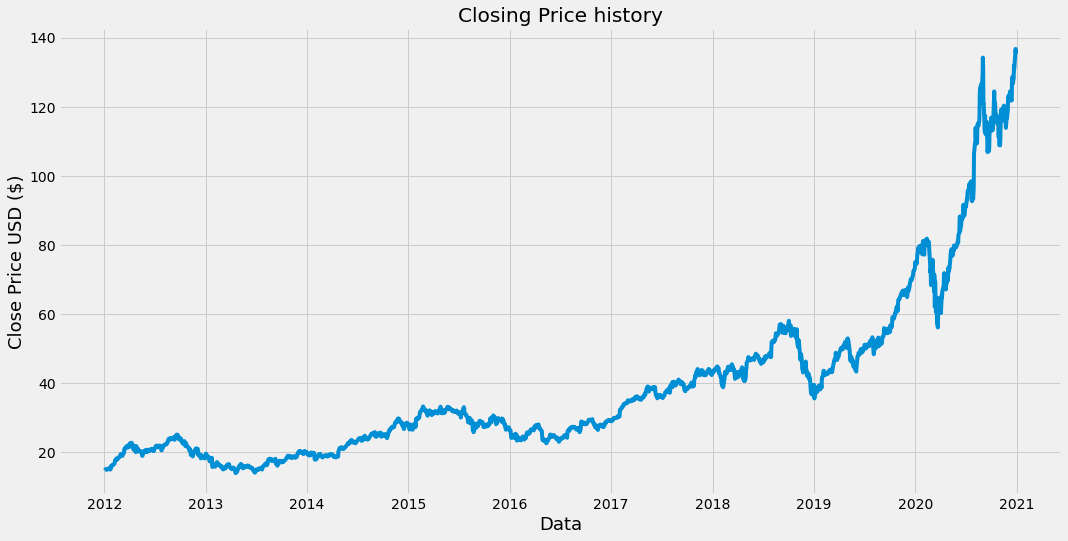

In [71]:
#Visualize closing price
plt.figure(figsize=(16,8))
plt.title('Closing Price history')
plt.plot(df['Close'])
plt.xlabel('Data',fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.show()


In [72]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.9) 

In [73]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [74]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [75]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [76]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [77]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [78]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [79]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1977/1977 [==============================] - 41s 20ms/step - loss: 8.4064e-04


In [80]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [81]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [82]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [83]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

11.562582127353812

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


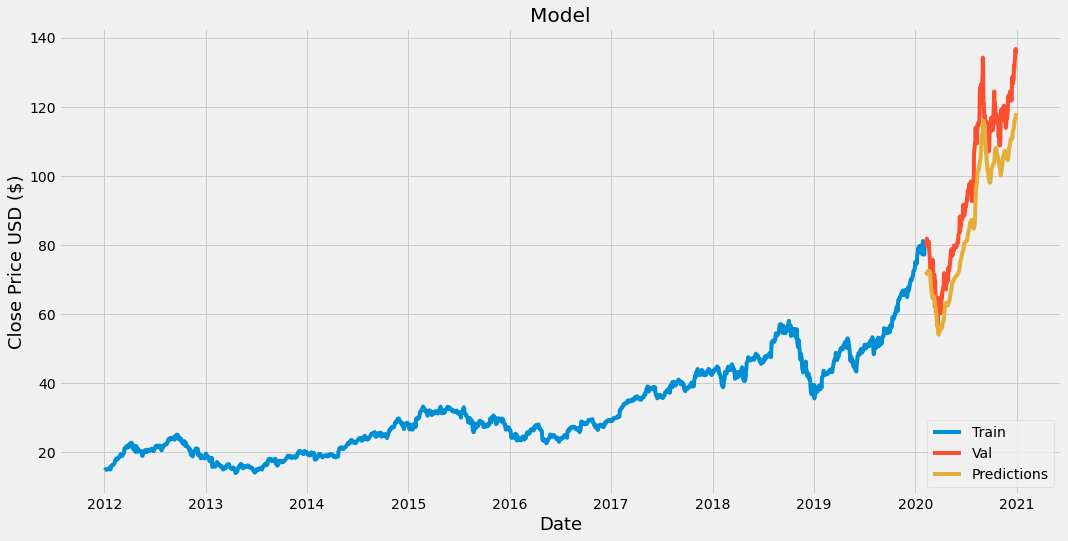

In [84]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [85]:
#Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2020-12-29')
#Create a new dataframe
new_df = apple_quote.filter(['Close'])
#Get teh last 60 day closing price 
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[119.287994]]


In [86]:
#Get the quote
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2020-12-28', end='2020-12-29')
print(apple_quote2['Close'])

Date
2020-12-28    136.690002
2020-12-29    135.440002
Name: Close, dtype: float64


In [87]:
valid

,Close,Predictions
Date,,
2020-02-07,80.007500,71.263527
2020-02-10,80.387497,71.481567
2020-02-11,79.902496,71.674507
2020-02-12,81.800003,71.769798
2020-02-13,81.217499,72.037277
...,...,...
2020-12-22,131.880005,114.060417
2020-12-23,130.960007,115.014328
2020-12-24,131.970001,115.887405


In [88]:
valid.shape

(226, 2)